# __Importing required libraries__

In [ ]:
import os
# import imageio
import numpy as np
from PIL import Image
import cv2
from skimage import io
from tqdm.auto import tqdm
from xml.etree import ElementTree
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import warnings
warnings.filterwarnings("ignore")
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchsummary import summary

# __Augmentation for face__

In [ ]:
class FaceAugmentation:
    def __init__(self,
                 image_dim,
                 brightness,    
                 contrast,
                 saturation,
                 hue,
                 face_offset,
                 crop_offset):
        
        self.image_dim = image_dim
        self.face_offset = face_offset
        self.crop_offset = crop_offset
        self.transform = transforms.ColorJitter(brightness, contrast, saturation, hue)
    
    def offset_crop(self, image, landmarks, crops_coordinates):
        left = int(crops_coordinates['left']) - self.face_offset
        top = int(crops_coordinates['top']) - self.face_offset
        width = int(crops_coordinates['width']) + (2 * self.face_offset)
        height = int(crops_coordinates['height']) + (2 * self.face_offset)

        image = TF.crop(image, top, left, height, width)
        landmarks = landmarks - np.array([[left, top]])

        new_dim = self.image_dim + self.crop_offset

        image = TF.resize(image, (new_dim, new_dim))

        landmarks[:, 0] *= new_dim / width
        landmarks[:, 1] *= new_dim / height

        return image, landmarks
    
    def random_face_crop(self, image, landmarks):
        image = np.array(image)

        h, w = image.shape[:2]

        top = np.random.randint(0, h - self.image_dim)
        left = np.random.randint(0, w - self.image_dim)

        image = image[top: top + self.image_dim, left: left + self.image_dim]

        landmarks = landmarks - np.array([[left, top]])

        return TF.to_pil_image(image), landmarks
    
    def __call__(self, image, landmarks, crops_coordinates):
        image, landmarks = self.offset_crop(image, landmarks, crops_coordinates)

        image, landmarks = self.random_face_crop(image, landmarks)

        return self.transform(image), landmarks

# __Augmentation for landmarks__

In [ ]:
class LandmarksAugmentation:
    def __init__(self, rotation_limit):
        self.rotation_limit = rotation_limit

    def random_rotation(self, image, landmarks):
        angle = np.random.uniform(-self.rotation_limit, self.rotation_limit)
        landmarks_transformation = np.array([
            [+np.cos(np.radians(angle)), -np.sin(np.radians(angle))], 
            [+np.sin(np.radians(angle)), +np.cos(np.radians(angle))]
        ])
        image = TF.rotate(image, angle)
        landmarks = landmarks - 0.5
        transformed_landmarks = np.matmul(landmarks, landmarks_transformation)
        transformed_landmarks = transformed_landmarks + 0.5

        return image, transformed_landmarks
    
    def __call__(self, image, landmarks):
        image, landmarks = self.random_rotation(image, landmarks)
        return image, landmarks

# __Data Preprocessing__

In [ ]:
class Preprocessor:
    def __init__(self,
                 image_dim,
                 brightness,
                 contrast,
                 saturation,
                 hue,
                 angle,
                 face_offset,
                 crop_offset):
        
        self.image_dim = image_dim

        self.landmarks_augmentation = LandmarksAugmentation(angle)
        self.face_augmentation = FaceAugmentation(image_dim, brightness, contrast, saturation, hue, face_offset, crop_offset)
    
    def __call__(self, image, landmarks, crops_coordinates):
        image = TF.to_pil_image(image)

        image, landmarks = self.face_augmentation(image, landmarks, crops_coordinates)

        landmarks = landmarks / np.array([*image.size])

        image, landmarks = self.landmarks_augmentation(image, landmarks)

        image = TF.to_grayscale(image)

        image = TF.to_tensor(image)

        image = (image - image.min())/(image.max() - image.min())
        image = (2 * image) - 1

        return image, torch.FloatTensor(landmarks.reshape(-1) - 0.5)

# __Creating the dataset class__

In [ ]:
class LandmarksDataset(Dataset):
    def __init__(self, preprocessor, train):
        self.root_dir = '/data/komedi/ibug_300W'
        
        self.image_paths = []
        self.landmarks = []
        self.crops = []
        self.preprocessor = preprocessor
        self.train = train
        
        tree = ElementTree.parse(os.path.join(self.root_dir, f'labels_ibug_300W_{"train" if train else "test"}.xml'))
        root = tree.getroot()
        
        for filename in root[2]:
            self.image_paths.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            num_list = [2, 5, 7, 9, 11, 13, 16, 18, 20, 22, 23, 25, 27, 28, 30, 31, 32, 34, 36, 37, 40, 43, 48, 49, 52, 55, 58]

            for num in num_list:
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_paths) == len(self.landmarks)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = io.imread(self.image_paths[index], as_gray = False)
        landmarks = self.landmarks[index]
        
        image, landmarks = self.preprocessor(image, landmarks, self.crops[index])

        return image, landmarks

# __Some helper functions for visualizing the data__

In [ ]:
def visualize_image(image, landmarks):
    plt.figure(figsize = (5, 5))
    image = (image - image.min())/(image.max() - image.min())

    landmarks = landmarks.view(-1, 2)
    landmarks = (landmarks + 0.5) * preprocessor.image_dim

    plt.imshow(image[0], cmap = 'gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 25, c = 'dodgerblue')
    plt.axis('off')
    plt.show()
    
def visualize_batch(images_list, landmarks_list, size = 14, shape = (6, 6), title = None, save = None):
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images_list, landmarks_list):
        image = (image - image.min())/(image.max() - image.min())

        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5) * preprocessor.image_dim
        landmarks = landmarks.numpy().tolist()
        landmarks = np.array([(x, y) for (x, y) in landmarks if 0 <= x <= preprocessor.image_dim and 0 <= y <= preprocessor.image_dim])

        ax.imshow(image[0], cmap = 'gray')
        ax.scatter(landmarks[:, 0], landmarks[:, 1], s = 10, c = 'dodgerblue')
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()

# __Initializing preprocessor, train and test images__

In [ ]:
preprocessor = Preprocessor(
    image_dim = 128,
    brightness = 0.24,
    saturation = 0.3,
    contrast = 0.15,
    hue = 0.14,
    angle = 14,
    face_offset = 32,
    crop_offset = 16)

train_images = LandmarksDataset(preprocessor, train = True)
test_images = LandmarksDataset(preprocessor, train = False)

# __Visualizing a sample image, with random augmentations__

In [ ]:
image1, landmarks1 = train_images[64]
visualize_image(image1, landmarks1)

image2, landmarks2 = train_images[64]
visualize_image(image2, landmarks2)

image3, landmarks3 = train_images[64]
visualize_image(image3, landmarks3)

In [ ]:
len_val_set = int(0.2 * len(train_images))
len_train_set = len(train_images) - len_val_set

print(f'{len_train_set} images for training')
print(f'{len_val_set} images for validating')
print(f'{len(test_images)} images for testing')

train_images, val_images = random_split(train_images, [len_train_set, len_val_set])

batch_size = 64
train_data = torch.utils.data.DataLoader(train_images, batch_size = batch_size, shuffle = True)
val_data = torch.utils.data.DataLoader(val_images, batch_size = 2 * batch_size, shuffle = False)
test_data = torch.utils.data.DataLoader(test_images, batch_size = 2 * batch_size, shuffle = False)

# __Visualizing a sample batch__

In [ ]:
for x, y in train_data:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

for x, y in val_data:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

for x, y in test_data:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

In [ ]:
visualize_batch(x[:16], y[:16], shape = (4, 4), size = 16, title = 'Training Batch Samples')

# __Creating Xception Net model architecture__

In [ ]:
class DepthewiseSeperableConv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super(DepthewiseSeperableConv2d, self).__init__()

        self.depthwise = nn.Conv2d(input_channels, input_channels, kernel_size, groups = input_channels, bias = False, **kwargs)
        self.pointwise = nn.Conv2d(input_channels, output_channels, 1, bias = False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x

In [ ]:
class EntryBlock(nn.Module):
    def __init__(self):
        super(EntryBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding = 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.conv3_residual = nn.Sequential(
            DepthewiseSeperableConv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride = 2, padding = 1),
        )

        self.conv3_direct = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride = 2),
            nn.BatchNorm2d(128),
        )

        self.conv4_residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.conv4_direct = nn.Sequential(
            nn.Conv2d(128, 256, 1, stride = 2),
            nn.BatchNorm2d(256),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        residual = self.conv3_residual(x)
        direct = self.conv3_direct(x)
        x = residual + direct
        
        residual = self.conv4_residual(x)
        direct = self.conv4_direct(x)
        x = residual + direct

        return x

In [ ]:
class MiddleBasicBlock(nn.Module):
    def __init__(self):
        super(MiddleBasicBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.conv2(residual)
        residual = self.conv3(residual)

        return x + residual


class MiddleBlock(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()

        self.block = nn.Sequential(*[MiddleBasicBlock() for _ in range(num_blocks)])

    def forward(self, x):
        x = self.block(x)

        return x

In [ ]:
class ExitBlock(nn.Module):
    def __init__(self):
        super(ExitBlock, self).__init__()

        self.residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.direct = nn.Sequential(
            nn.Conv2d(256, 512, 1, stride = 2),
            nn.BatchNorm2d(512)
        )

        self.conv = nn.Sequential(
            DepthewiseSeperableConv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(512, 1024, 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
        )

        self.dropout = nn.Dropout(0.5)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        direct = self.direct(x)
        residual = self.residual(x)
        x = direct + residual
        
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.dropout(x)

        return x

# __Initializing the Xception Net model__

In [ ]:
class XceptionNet(nn.Module):
    def __init__(self, num_classes, num_middle_blocks = 6):
        super(XceptionNet, self).__init__()
        self.num_classes = num_classes
        self.entry_block = EntryBlock()
        self.middel_block = MiddleBlock(num_middle_blocks)
        self.exit_block = ExitBlock()

        self.fc = nn.Linear(1024, self.num_classes)

    def forward(self, x):
        x = self.entry_block(x)
        x = self.middel_block(x)
        x = self.exit_block(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc(x)

        return x

In [ ]:
model = XceptionNet(num_classes=27*2)
model = model.cuda()

In [ ]:
# summary(model, (1, 128, 128))

# __Initializing the objective loss and optimizer__

In [ ]:
objective = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0008)

# __Defining validation function__

In [ ]:
@torch.no_grad()
def validate(save = None):
    cum_loss = 0.0

    model.eval()

    for features, labels in tqdm(val_data, desc = 'Validating', ncols = 600):
        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features)

        loss = objective(outputs, labels)

        cum_loss += loss.item()

        break
        
    visualize_batch(features[:16].cpu(), outputs[:16].cpu(), shape = (4, 4), size = 16, title = 'Validation sample predictions', save = save)

    return cum_loss/len(val_data)

validate()

# Creating directory for storing the model's progress

In [ ]:
if os.path.isdir('/home/ubuntu/workspace/FLD-scratch/src/jupyter/progress_2'):
    !rm -rf progress
os.mkdir('/home/ubuntu/workspace/FLD-scratch/src/jupyter/progress_2')

# __And finally training the model__

Validating:   0%|                                                                                             …

Validation sample predictions


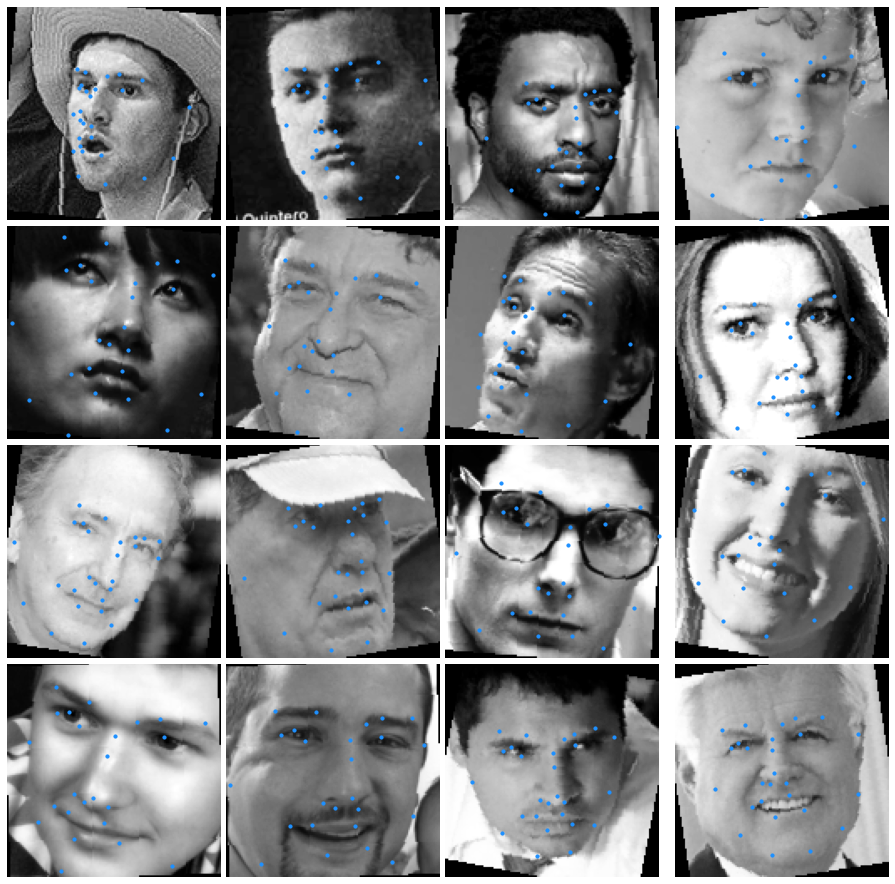

Saving model....................
Epoch(20/100) -> Training Loss: 0.00107450 | Validation Loss: 0.00007187


Epoch(21/100):   0%|                                                                                          …

Validating:   0%|                                                                                             …

Validation sample predictions


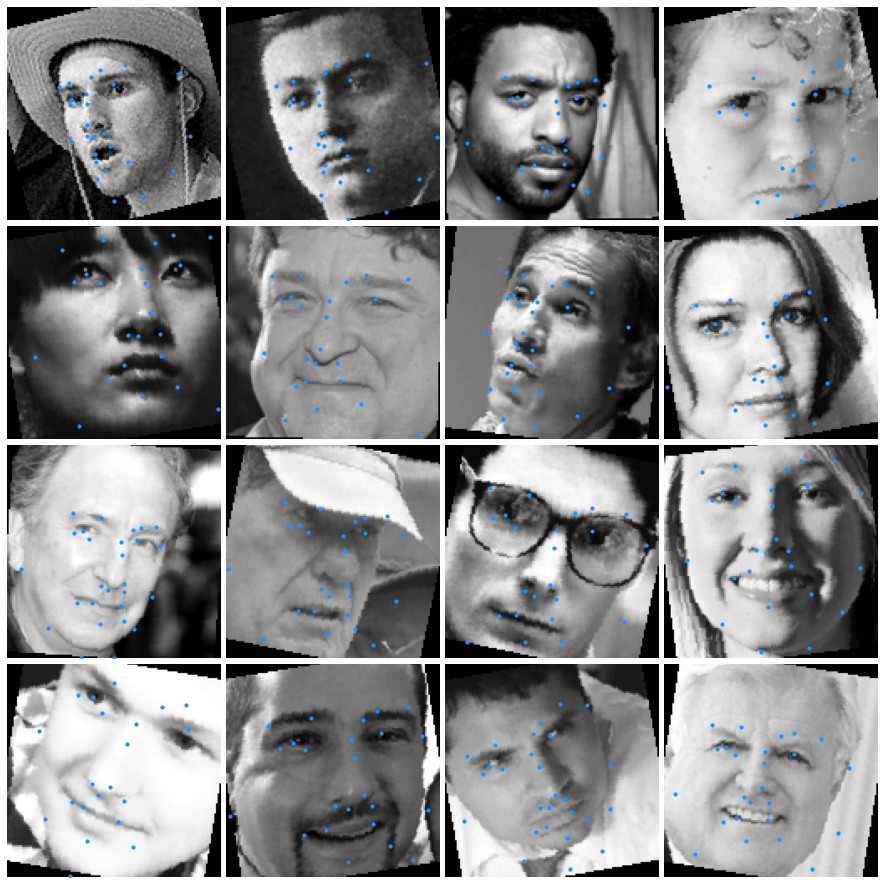

Epoch(21/100) -> Training Loss: 0.00105937 | Validation Loss: 0.00011915


Epoch(22/100):   0%|                                                                                          …

Validating:   0%|                                                                                             …

Validation sample predictions


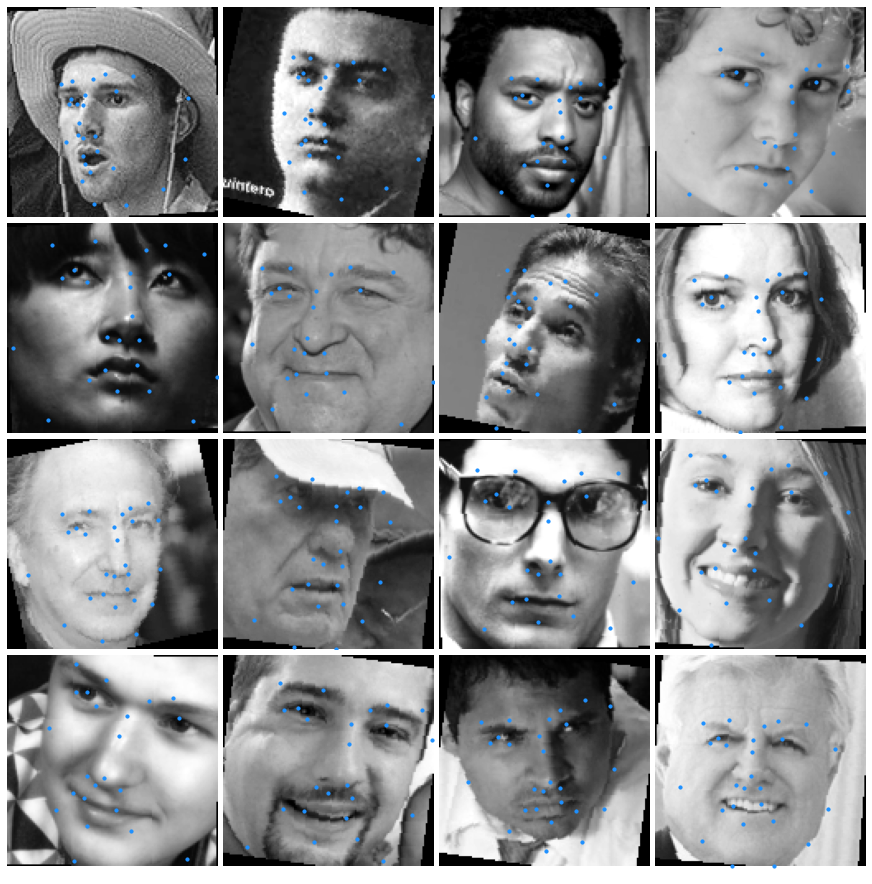

Epoch(22/100) -> Training Loss: 0.00106161 | Validation Loss: 0.00009250


Epoch(23/100):   0%|                                                                                          …

In [22]:
epochs = 100
batches = len(train_data)
best_loss = np.inf
optimizer.zero_grad()

for epoch in range(epochs):
    cum_loss = 0.0

    model.train()
    for batch_index, (features, labels) in enumerate(tqdm(train_data, desc = f'Epoch({epoch + 1}/{epochs})', ncols = 800)):
        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features)
        
        loss = objective(outputs, labels)

        loss.backward()

        optimizer.step()
        
        optimizer.zero_grad()

        cum_loss += loss.item()

    val_loss = validate(os.path.join('progress', f'epoch({str(epoch + 1).zfill(len(str(epochs)))}).jpg'))

    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model....................')
        save_model = '/home/ubuntu/workspace/FLD-scratch/src/pretrained_model/xcep_27pt_100epoch_drop05.pt'
        torch.save(model.state_dict(), save_model)

    print(f'Epoch({epoch + 1}/{epochs}) -> Training Loss: {cum_loss/batches:.8f} | Validation Loss: {val_loss:.8f}')

# __Inference__

In [ ]:
model.load_state_dict(torch.load(save_model, map_location = 'cpu'))

In [ ]:
import dlib
from imutils import face_utils
from moviepy.editor import VideoFileClip

In [ ]:
def preprocess_image(image):
    image = TF.to_pil_image(image)
    image = TF.resize(image, (128, 128))
    image = TF.to_tensor(image)
    image = (image - image.min())/(image.max() - image.min())
    image = (2 * image) - 1
    return image.unsqueeze(0)

def draw_landmarks_on_faces(image, faces_landmarks):
    image = image.copy()
    for landmarks, (left, top, height, width) in faces_landmarks:
        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5)
        landmarks = landmarks.numpy()
        
        for i, (x, y) in enumerate(landmarks, 1):
            try:
                cv2.circle(image, (int((x * width) + left), int((y * height) + top)), 2, [40, 117, 255], -1)
            except:
                pass
    
    return image

In [ ]:
face_detector = dlib.get_frontal_face_detector()

@torch.no_grad()
def inference(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    faces = face_detector(gray, 1)

    outputs = []

    for (i, face) in enumerate(faces):
        (x, y, w, h) = face_utils.rect_to_bb(face)

        crop_img = gray[y: y + h, x: x + w]
        preprocessed_image = preprocess_image(crop_img)
        landmarks_predictions = model(preprocessed_image.cuda())
        outputs.append((landmarks_predictions.cpu(), (x, y, h, w)))

    return draw_landmarks_on_faces(frame, outputs)

In [ ]:
def output_video(video, name, seconds = None):
    total = int(video.fps * seconds) if seconds else int(video.fps * video.duration)
    print('Will read', total, 'images...')
    
    outputs = []

    writer = cv2.VideoWriter(name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), video.fps, tuple(video.size))

    for i, frame in enumerate(tqdm(video.iter_frames(), total = total), 1):    
        if seconds:
            if (i + 1) == total:
                break
                
        output = inference(frame)
        outputs.append(output)

        writer.write(cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

    writer.release()

    return outputs

In [ ]:
video = VideoFileClip("/home/ubuntu/workspace/FLD-scratch/olds/video_example/Steve Jobs on Quality-kib6uXQsxBA.mp4")
print('FPS:', video.fps)
print('Duration:', video.duration, 'seconds')

In [ ]:
for frame in video.iter_frames():
    break

print(frame.shape)
plt.figure(figsize = (11, 11))
plt.imshow(frame)

In [ ]:
outputs = output_video(video, '/home/ubuntu/workspace/FLD-scratch/src/jupyter/jobs_output_2')

In [ ]:
plt.figure(figsize = (11, 11))
plt.imshow(outputs[10]) # yayaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa